# <center> Predicting AFL Match Results with XGBoost </center>
<img src="afl_logo.png"/>

## <center>Beating the bookies for fun and profit!</center>

## What is AFL?

The AFL is the Australian Rules Football League. You work/study in Melbourne so you'll have a hard time avoiding it.

## What is XGBoost?
XGBoost is a machine learning (ML) package for creating supervised classification models for use with tabular data. The method used by XGBoost is a gradient boosted random forest... I will describe this at a high level, but there is a lot more information available on the XGBoost website (as well as all over the internet). At the moment, XGBoost is among the most popular methods used in data science because it allows you to create surprisingly accurate models with minimal effort (as you'll see here...). If you're familiar with Kaggle, you will find that for contests with tabular data, XGBoost is very commonly found among the top performers. 

### Random forest??

A random forest is a particular type of ML method that uses an ensemble of "decision trees" to classify some object based on its various "features". An individual decision tree is essentially a flow chart that one might follow to make a decision, the basic structure looks like this:
<img src="decision_tree1.png"/>

and here is an example with actual decisions:
<img src="decision_tree2.jpg"/>

Individual decision trees can be complex, but will have limitations as any individual tree will consider certain features of your data more important than others. While this is likely justified, there will be exceptions and these will be misclassified. 

This is where a "random forest" comes in. A random forest is simply an ensemble of many individual decision trees that each have slightly different structures. When a random forest is applied to a given set of observations, it will apply each individual decision tree and then determine the ultimate classification from the most frequent classification among each individual classification. 

### Gradient Boosting?

The other aspect of XGBoost is gradient boosting. In a nutshell, XGBoost first creates one decision tree to classify the training data then applies this tree and checks how many items were misclassified and quantifies this using a "loss function". Next, a second tree is added that attempts to account for the failures of the previous tree. In this sense the new tree is fit to the residual of the previous model, and the new model is the linear combination of the first and second trees. This process is repeated until a level of convergence is reached. It turns out that the residual in each case is related to the derivative of the loss function, and this is the origin of the term "gradient boosting".

This explanation obviously leaves a lot to be desired, so if you want to know more just Google it. XGBoost In order to use XGBoost effectively, you don't actually need to know any of this. The purpose of this notebook is simply to show you how to get started with preparing your data, creating an XGBoost model, tuning hyper-parameters, and doing some basic interpretation of the results. 

## The Data:

(_The data for this project was scraped from an AFL stats website using the package Beautiful Soup. I was going to give a quick tutorial on web scraping HTML tables, but while writing and testing my scraping script I believe that I was identified as a malicious entity and subsequently blocked. I was able to get around this once and finish scraping the data that I wanted and now that its collected I'm going to leave it alone..._)

I've acquired match data for all AFL matches for seasons 2008-2019, and focused on only extacting features that would be available before the match took place as these will be the features that can be used to predict the winner of a future match. These features include things like home and team win percentages, venue, game time/date, home/away team average goals per game, among others. Data for each year have been saved in a numpy .npz file, but a pandas dataframe would work just as well (maybe better).

### Data Preparation

The majority of your time when working on a ML project will be spent preparing your data and getting it into a format appropriate for the particular ML method you'd like to use. In this case, each match will be represented by a vector or numbers representing the various "features" we've extracted and a result that we are trying to predict. We must first come up with a standard format for the data.

For the results, we will be predicting whether or not the home team has won or lost the match with a win represented by a 1 and a loss represented by a 0 (I'm going to ignore draws because these are pretty rare so failing to predict if a match is a draw is not going to hurt our accuracy much...). Thus, the results will simply be a long list of 0's and 1's with a length equal to the number of matches that have been extracted. 

For the features, each match will be represented by 21 values:

1. Round Number
2. Venue
3. Home Team
4. Away Team
5. Time
6. Average Player Age (home team)
7. Total Games (home team)
8. Win Percentage (home team)
9. Total Goals (home team)
10. Average Goals per Game (home team)
11. Coach Age (home team)
12. Total Games (home team coach)
13. Win Percentage (home team coach)
14. Average Player Age (away team)
15. Total Games (away team)
16. Win Percentage (away team)
17. Total Goals (away team)
18. Average Goals per Game (away team)
19. Coach Age (away team)
20. Total Games (away team coach)
21. Win Percentage (away team coach)

The venue and team names are obviously represented by strings, so we first have to collect all possible values for these and assign them a number arbitrarily. Then for each game features, the venue and team names are replaced by this numerical value (try one hot encoding?). Although there is some ordering here (i.e. the home team stats are listed followed by the away team stats), but the order here actually doesn't matter at all. The order could be entirely randomised and, so long as the same ordering is used for every match, the results should be identical. XGBoost doesn't actually know what any of these things are or what their actual significance is, it just identifies  abstract mathematical patterns between them to classify each match.

### OK, lets load the data and have a look.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataprep import get_hash_tables, load_year

seasons = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
# get_hash_tables loads all the team and venue names for all seasons and
# constructs two hash tables with a unique, numerical values for each
team_hash_table,venue_hash_table = get_hash_tables(seasons)

for key in team_hash_table.keys():
    print(key,team_hash_table[key])

Carlton 0
Port Adelaide 1
Collingwood 2
West Coast 3
St Kilda 4
Western Bulldogs 5
Hawthorn 6
North Melbourne 7
Brisbane Lions 8
Adelaide 9
Fremantle 10
Sydney 11
Geelong 12
Richmond 13
Essendon 14
Melbourne 15
Gold Coast 16
Greater Western Sydney 17


In [31]:
# Now load the data for each game and pass it through the function "load_year"
# which formats it into the 21 length vector described above
X,Y = load_year('./2008_data.npz',team_hash_table,venue_hash_table)
for yr in ['09','10','11','12','13','14','15','16','17','18','19']:
    x,y = load_year(f'./20{yr}_data.npz',team_hash_table,venue_hash_table)
    X = np.vstack((X,x))
    Y = np.concatenate((Y,y))
    
print('Features:',X[0])
print('Results:',Y[0])

Features: [1.0000e+00 0.0000e+00 0.0000e+00 1.3000e+01 6.1000e+02 8.5600e+03
 1.4170e+03 3.2390e+01 1.0770e+03 7.6000e-01 1.3393e+04 7.0000e+00
 0.0000e+00 9.0830e+03 1.9820e+03 3.9350e+01 1.8040e+03 9.1000e-01
 1.7983e+04 2.1500e+02 4.9070e+01]
Results: 0


We can see based on the 3rd and 4th values that this match was between home team Carlton (team 0) and away team Richmond (team 13) and that Carlton lost (result = 0, home team lost).

In [3]:
# Here we see that X is a 2077x21 array, so we have data for 2077 matches for training and testing our model
print(X.shape)

(2077, 21)


There is probably more feature engineering I can do here that could ultimately result in better model accuracy, but lets just move forward with these "raw" features and see how well we can do. The next step is to split the data:

### Train-Test Splitting:

It's important to split your data into a training and testing set as XGBoost can often come up with a model that can predict the data its trained on with very high accuracy, but this is not reflective of how accurate the model will be when presented with new data. To test the _true_ accuracy of the model, you must provide some data that it hasn't seen yet and see how well it can predict this. For even more rigorous modelling you can do something called K-fold cross-validation, but I'll leave that to you to explore.

Often times you will see tutorials using train_test_split (or similar) from sklearn.model_selection for doing this. This will randomly split your entire dataset into two groups. In this case, games come in groups of seasons, so we want to avoid a situation where certain permutations are excluded from the training set (e.g. no Carlton matches, no round 1 matches, etc), so we are simply going to use seasons from 2008 to 2017 as our training set then reserve 2018 and 2019 seasons for testing our model:



In [20]:
"""
This is how train test split works in sklearn just FYI

from sklearn.model_selection import train_test_split

# Here the kwarg "test_size" tells the sklearn what fraction of the data
# to reserve for testing the model. In this case 30% of the data is reserved.
# Note that this splitting is done randomly, so if you run this twice you can
# get two different training sets that will ultimately result in two slightly
# different models. If you want to return the same split every time, which
# may be useful for testing, train_test_split has another kwarg "random_state"
# that determines the initial seed and can be set to some arbitrary number.

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)
"""
X,Y = load_year('./2008_data.npz',team_hash_table,venue_hash_table)
for yr in ['09','10','11','12','13','14','15','16','17']:
    x,y = load_year(f'./20{yr}_data.npz',team_hash_table,venue_hash_table)
    X = np.vstack((X,x))
    Y = np.concatenate((Y,y))

X_train,y_train = X,Y
X_test1,y_test1 = load_year('./2018_data.npz',team_hash_table,venue_hash_table)
X_test2,y_test2 = load_year('./2019_data.npz',team_hash_table,venue_hash_table)

print(f'Training set size: {len(y_train)}')
print(f'Test set 1 size: {len(y_test1)}')
print(f'Test set 2 size: {len(y_test2)}')

Training set size: 1723
Test set 1 size: 177
Test set 2 size: 177


In [19]:
feature_labels = [
    'round num',
    'venue',
    'home team',
    'away team',
    'time',
    'avg age(home)',
    'games (home)',
    'win perc(home)',
    'goals (home)',
    'avg goals (home)',
    'coach age (home)',
    'coach games (home)',
    'coach win perc (home)',
    'avg age (away)',
    'games (away)',
    'win perc (away)',
    'goals (away)',
    'avg goals (away)',
    'coach age (away)',
    'coach games (away)',
    'coach win perc (away)'
]

X_train = pd.DataFrame(data=X_train,columns=feature_labels)
X_test1 = pd.DataFrame(data=X_test1,columns=feature_labels)
X_test2 = pd.DataFrame(data=X_test2,columns=feature_labels)

## Initialising Hyper-Parameters:

Now we need to set up the hyperparamters that XGBoost will use for building the model. The model will be somewhat sensitive to these parameters, so later we will see how to tune these to get the best performance. For now we will just put in some values that are in the ranges typical for XGBoost models (you can Google this):

In [7]:
# Here the "objective" is set to "binary:logistic" which just means we are
# doing binary classification since the result is either 0 or 1, and that we
# are doing this by logistic regression. Ultimately this is important and
# the selection will depend on the exact classification task you are performing.
# I will also leave this to you to look into further if you want to use XGBoost
# for your own problems.

xg_par = {
    'objective':'binary:logistic',
    'colsample_bytree':.1,
    'subsample':.2,
    'learning_rate':.001,
    'gamma':12,
    'max_depth':2,
    'reg_alpha':0.3,
    'eval_metric':'error',
}

### Training the Model:
We're going to use the sklearn style XGBoost for this

In [32]:
from xgboost.sklearn import XGBClassifier,XGBRegressor

# Set up the model using the parameters we specified:
xg_mod = XGBClassifier(**xg_par,)

# Train the model:
xg_mod.fit(X_train,y_train)

# Use the trained model to predict the test set results:
pred1 = xg_mod.predict(X_test1)
print(pred1)
pred2 = xg_mod.predict(X_test2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1]


Now we just need to compare this with the test set's actual results to evaluate the accuracy of this model:

In [10]:
from sklearn.metrics import balanced_accuracy_score as acc

print(f'2018 accuracy: {acc(y_test1,pred1)}')
print(f'2019 accuracy: {acc(y_test2,pred2)}')

2018 accuracy: 0.5664961636828645
2019 accuracy: 0.5519607843137255


Considering this is a binary classification, flipping a coin should yield 0.5, so this clearly hasn't been worth the trouble at this point (though its likely already a significant improvement on my footy tipping efforts which I suspect would have been improved by flipping a coin...)

How can we do better? The are a few things that we could try:

1. We can try to get more features that may be better predictors of wether or not the home team would win. These can either be completely new features that weren't included here, or some combination of the features we already used to create a new feature. This could be time consuming...

2. Try a different type of model (e.g. neural network). Typically XGBoost is going to be as good or better than any other type of model for this type of problem (though there are exceptions of course). Really, the best bet is to get new features, because the power of ML is in the data: if you can identify the key features that are most predictive for your problem you will get the best results.

3. We can "tune" the hyperparamters and determine the exact values that provide the most accurate model. There is a lot of info on how to do this fairly simply, so it really doesn't cost you much to try this first. If you don't achieve the improvement you wanted here, you can then go back and try to get new features. We'll try this for now.

### Hyperparameter Tuning:

In the model we created above we simply semi-randomly selected some input hyperparameters for XGBoost based on the typical values you usually see online. There is likely a set of hyperparameters that will do a better job, though, so the process of hyperparameter tuning is a way of determining which are the best parameters. There are different ways to do this, including some built in methods in sklearn like grid search and random search. In both cases, you supply a discrete set of parameter values to test. Grid search is a brute force method that tests all possible combinations while the random search just takes a random sampling. The former takes much longer but covers all possibilities, we'll try a grid search here. I'm not using a lot of parameter options just to make it run faster.

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.02,0.05], #so called `eta` value
              'max_depth': [8,10],
              'min_child_weight': [1,10],
              'silent': [1],
              'subsample': [0.5,1.],
              'colsample_bytree': [0.7],
              'n_estimators': [150],
              'seed': [1337]}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)
xg_tuned = XGBClassifier()
grid = GridSearchCV(xg_tuned, 
                        param_grid=parameters,
                        n_jobs=4,
                        cv=skf.split(X_train,y_train), 
                        scoring='roc_auc',
                        verbose=3, refit=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:   39.4s finished


[14:59:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=<generator object _BaseKFold.split at 0x1a189ab750>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mon...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.7],
                         'learni

In [12]:
best = grid.best_params_
print(best)
xg_tuned = XGBClassifier(**best)
xg_tuned.fit(X_train,y_train)
pred1 = xg_tuned.predict(X_test1)
pred2 = xg_tuned.predict(X_test2)
print(f'2018 accuracy = {acc(y_test1,pred1)}')
print(f'2019 accuracy = {acc(y_test2,pred2)}')

{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 150, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 1.0}
[15:00:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


2018 accuracy = 0.7207161125319693
2019 accuracy = 0.634313725490196


Wow, ok we're now doing 8-16% better just by choosing better hyperparameters with a fairly narrow grid search!
We can do something a bit more rigorous using method of hyperparameter tuning that is gaining in popularity employing Bayesian optimization. One package to do this is hyperopt, which can be installed with pip. This differs from grid/random searches because you provide a continuous value range for each parameter you want to tune rather than discrete values. This avoids the situation where you've done a grid search but failed to include the optimal combination:

In [16]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


parameter_space ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
                  'gamma': hp.uniform ('gamma', 0,9),
                  'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
                  'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
                  'learning_rate' : hp.uniform('learning_rate',0.02,0.1),
                  'subsample' : hp.uniform('subsample',0.5,1.),
                  'n_estimators': 1000
}

def hyperparameter_tuning(space):
    model = XGBClassifier(
        objective = 'binary:logistic',
        max_depth = int(space['max_depth']),
        gamma = space['gamma'],
        colsample_bytree = space['colsample_bytree'],
        min_child_weight = space['min_child_weight'],
        learning_rate = space['learning_rate'],
        n_estimators = int(space['n_estimators']),
        seed = 1337
    )
    evals = [(X_test1,y_test1), (X_test2,y_test2)]
    
    model.fit(X_train,y_train,eval_metric='rmse',eval_set=evals,early_stopping_rounds=10)
    pred1 = model.predict(X_test1)
    pred2 = model.predict(X_test2)
    accuracy = np.mean([acc(y_test1, pred1),acc(y_test2, pred2)])
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=parameter_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

[0]	validation_0-rmse:0.49596	validation_1-rmse:0.49658

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.

[1]	validation_0-rmse:0.49232	validation_1-rmse:0.49382

[2]	validation_0-rmse:0.48861	validation_1-rmse:0.49114

[3]	validation_0-rmse:0.48529	validation_1-rmse:0.48919

[4]	validation_0-rmse:0.48212	validation_1-rmse:0.48673

[5]	validation_0-rmse:0.47863	validation_1-rmse:0.48471

[6]	validation_0-rmse:0.47582	validation_1-rmse:0.48399

[7]	validation_0-rmse:0.47361	validation_1-rmse:0.48167

[8]	validation_0-rmse:0.47093	validation_1-rmse:0.48008

[9]	validation_0-rmse:0.46874	validation_1-rmse:0.47877

[10]	validation_0-rmse:0.46669	validation_1-rmse:0.47768

[11]	validation_0-rmse:0.46483	validation_1-rmse:0.47657

[12]	validation_0-rmse:0.46253	validation_1-rmse:0.47527

[13]	validation_0-rmse:0.46227	validation_1-rmse:0.47497

[14]	validation_0-rmse:0.46038	valida

[3]	validation_0-rmse:0.49082	validation_1-rmse:0.49299                           

[4]	validation_0-rmse:0.48728	validation_1-rmse:0.49109                           

[5]	validation_0-rmse:0.48490	validation_1-rmse:0.48971                           

[6]	validation_0-rmse:0.48303	validation_1-rmse:0.48862                           

[7]	validation_0-rmse:0.48136	validation_1-rmse:0.48771                           

[8]	validation_0-rmse:0.47912	validation_1-rmse:0.48591                           

[9]	validation_0-rmse:0.47775	validation_1-rmse:0.48474                           

[10]	validation_0-rmse:0.47628	validation_1-rmse:0.48442                          

[11]	validation_0-rmse:0.47404	validation_1-rmse:0.48267                          

[12]	validation_0-rmse:0.47347	validation_1-rmse:0.48165                          

[13]	validation_0-rmse:0.47208	validation_1-rmse:0.48053                          

[14]	validation_0-rmse:0.47031	validation_1-rmse:0.48000                    

[29]	validation_0-rmse:0.44447	validation_1-rmse:0.46949                          

[30]	validation_0-rmse:0.44397	validation_1-rmse:0.46794                          

[31]	validation_0-rmse:0.44305	validation_1-rmse:0.46883                          

[32]	validation_0-rmse:0.44221	validation_1-rmse:0.46767                          

[33]	validation_0-rmse:0.44234	validation_1-rmse:0.46808                          

[34]	validation_0-rmse:0.44167	validation_1-rmse:0.46760                          

[35]	validation_0-rmse:0.44143	validation_1-rmse:0.46771                          

[36]	validation_0-rmse:0.44186	validation_1-rmse:0.46721                          

[37]	validation_0-rmse:0.44133	validation_1-rmse:0.46703                          

[38]	validation_0-rmse:0.44151	validation_1-rmse:0.46753                          

[39]	validation_0-rmse:0.44165	validation_1-rmse:0.46713                          

[40]	validation_0-rmse:0.44141	validation_1-rmse:0.46807                    

[17]	validation_0-rmse:0.46907	validation_1-rmse:0.47871                          

[18]	validation_0-rmse:0.46796	validation_1-rmse:0.47789                          

[19]	validation_0-rmse:0.46649	validation_1-rmse:0.47727                          

[20]	validation_0-rmse:0.46589	validation_1-rmse:0.47679                          

[21]	validation_0-rmse:0.46540	validation_1-rmse:0.47626                          

[22]	validation_0-rmse:0.46482	validation_1-rmse:0.47555                          

[23]	validation_0-rmse:0.46310	validation_1-rmse:0.47474                          

[24]	validation_0-rmse:0.46241	validation_1-rmse:0.47453                          

[25]	validation_0-rmse:0.46220	validation_1-rmse:0.47416                          

[26]	validation_0-rmse:0.46146	validation_1-rmse:0.47379                          

[27]	validation_0-rmse:0.46065	validation_1-rmse:0.47366                          

[28]	validation_0-rmse:0.46029	validation_1-rmse:0.47351                    

[35]	validation_0-rmse:0.47067	validation_1-rmse:0.46869                          

[36]	validation_0-rmse:0.46978	validation_1-rmse:0.46817                          

[37]	validation_0-rmse:0.46863	validation_1-rmse:0.46737                          

[38]	validation_0-rmse:0.46819	validation_1-rmse:0.46691                          

[39]	validation_0-rmse:0.46746	validation_1-rmse:0.46699                          

[40]	validation_0-rmse:0.46638	validation_1-rmse:0.46627                          

[41]	validation_0-rmse:0.46623	validation_1-rmse:0.46603                          

[42]	validation_0-rmse:0.46585	validation_1-rmse:0.46573                          

[43]	validation_0-rmse:0.46482	validation_1-rmse:0.46617                          

[44]	validation_0-rmse:0.46506	validation_1-rmse:0.46591                          

[45]	validation_0-rmse:0.46496	validation_1-rmse:0.46541                          

[46]	validation_0-rmse:0.46549	validation_1-rmse:0.46548                    

[55]	validation_0-rmse:0.44332	validation_1-rmse:0.46680                          

[56]	validation_0-rmse:0.44332	validation_1-rmse:0.46642                          

[57]	validation_0-rmse:0.44307	validation_1-rmse:0.46660                          

[58]	validation_0-rmse:0.44288	validation_1-rmse:0.46682                          

[59]	validation_0-rmse:0.44243	validation_1-rmse:0.46666                          

[60]	validation_0-rmse:0.44220	validation_1-rmse:0.46703                          

[61]	validation_0-rmse:0.44213	validation_1-rmse:0.46671                          

[62]	validation_0-rmse:0.44271	validation_1-rmse:0.46722                          

[63]	validation_0-rmse:0.44276	validation_1-rmse:0.46729                          

[64]	validation_0-rmse:0.44240	validation_1-rmse:0.46803                          

[65]	validation_0-rmse:0.44237	validation_1-rmse:0.46802                          

[66]	validation_0-rmse:0.44237	validation_1-rmse:0.46778                    

[81]	validation_0-rmse:0.44533	validation_1-rmse:0.46404                          

[82]	validation_0-rmse:0.44529	validation_1-rmse:0.46373                          

[83]	validation_0-rmse:0.44539	validation_1-rmse:0.46361                          

[84]	validation_0-rmse:0.44513	validation_1-rmse:0.46381                          

[85]	validation_0-rmse:0.44479	validation_1-rmse:0.46397                          

[86]	validation_0-rmse:0.44489	validation_1-rmse:0.46396                          

[87]	validation_0-rmse:0.44463	validation_1-rmse:0.46385                          

[88]	validation_0-rmse:0.44441	validation_1-rmse:0.46364                          

[89]	validation_0-rmse:0.44442	validation_1-rmse:0.46367                          

[90]	validation_0-rmse:0.44445	validation_1-rmse:0.46361                          

[91]	validation_0-rmse:0.44433	validation_1-rmse:0.46355                          

[92]	validation_0-rmse:0.44432	validation_1-rmse:0.46357                    

[30]	validation_0-rmse:0.44189	validation_1-rmse:0.46213                          

[31]	validation_0-rmse:0.44256	validation_1-rmse:0.46238                          

[32]	validation_0-rmse:0.44252	validation_1-rmse:0.46253                          

[33]	validation_0-rmse:0.44224	validation_1-rmse:0.46198                          

[34]	validation_0-rmse:0.44226	validation_1-rmse:0.46198                          

Stopping. Best iteration:                                                         
[24]	validation_0-rmse:0.44475	validation_1-rmse:0.46159


[0]	validation_0-rmse:0.49275	validation_1-rmse:0.49514                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.48538	validation_1-rmse:0.49080                            

[2]	validation_0-rmse:0.47738	validation_1-rmse:0.48478                            

[3]

[64]	validation_0-rmse:0.46435	validation_1-rmse:0.46810                          

[65]	validation_0-rmse:0.46411	validation_1-rmse:0.46779                          

[66]	validation_0-rmse:0.46359	validation_1-rmse:0.46749                          

[67]	validation_0-rmse:0.46331	validation_1-rmse:0.46719                          

[68]	validation_0-rmse:0.46303	validation_1-rmse:0.46688                          

[69]	validation_0-rmse:0.46312	validation_1-rmse:0.46683                          

[70]	validation_0-rmse:0.46313	validation_1-rmse:0.46666                          

[71]	validation_0-rmse:0.46281	validation_1-rmse:0.46650                          

[72]	validation_0-rmse:0.46264	validation_1-rmse:0.46626                          

[73]	validation_0-rmse:0.46251	validation_1-rmse:0.46609                          

[74]	validation_0-rmse:0.46241	validation_1-rmse:0.46575                          

[75]	validation_0-rmse:0.46241	validation_1-rmse:0.46558                    

[19]	validation_0-rmse:0.45200	validation_1-rmse:0.46956                          

[20]	validation_0-rmse:0.45104	validation_1-rmse:0.46975                          

[21]	validation_0-rmse:0.45040	validation_1-rmse:0.46921                          

[22]	validation_0-rmse:0.45026	validation_1-rmse:0.46942                          

[23]	validation_0-rmse:0.44943	validation_1-rmse:0.46877                          

[24]	validation_0-rmse:0.44934	validation_1-rmse:0.46827                          

[25]	validation_0-rmse:0.44909	validation_1-rmse:0.46848                          

[26]	validation_0-rmse:0.44837	validation_1-rmse:0.46816                          

[27]	validation_0-rmse:0.44839	validation_1-rmse:0.46786                          

[28]	validation_0-rmse:0.44786	validation_1-rmse:0.46802                          

[29]	validation_0-rmse:0.44793	validation_1-rmse:0.46831                          

[30]	validation_0-rmse:0.44791	validation_1-rmse:0.46802                    

[55]	validation_0-rmse:0.44698	validation_1-rmse:0.46930                          

[56]	validation_0-rmse:0.44692	validation_1-rmse:0.46861                          

[57]	validation_0-rmse:0.44647	validation_1-rmse:0.46817                          

[58]	validation_0-rmse:0.44700	validation_1-rmse:0.46825                          

[59]	validation_0-rmse:0.44731	validation_1-rmse:0.46796                          

[60]	validation_0-rmse:0.44701	validation_1-rmse:0.46775                          

[61]	validation_0-rmse:0.44629	validation_1-rmse:0.46781                          

[62]	validation_0-rmse:0.44665	validation_1-rmse:0.46810                          

[63]	validation_0-rmse:0.44657	validation_1-rmse:0.46759                          

[64]	validation_0-rmse:0.44695	validation_1-rmse:0.46805                          

[65]	validation_0-rmse:0.44699	validation_1-rmse:0.46821                          

[66]	validation_0-rmse:0.44679	validation_1-rmse:0.46782                    

[22]	validation_0-rmse:0.46371	validation_1-rmse:0.47478                           

[23]	validation_0-rmse:0.46226	validation_1-rmse:0.47403                           

[24]	validation_0-rmse:0.46168	validation_1-rmse:0.47362                           

[25]	validation_0-rmse:0.46146	validation_1-rmse:0.47327                           

[26]	validation_0-rmse:0.46053	validation_1-rmse:0.47326                           

[27]	validation_0-rmse:0.45974	validation_1-rmse:0.47331                           

[28]	validation_0-rmse:0.45923	validation_1-rmse:0.47315                           

[29]	validation_0-rmse:0.45876	validation_1-rmse:0.47297                           

[30]	validation_0-rmse:0.45804	validation_1-rmse:0.47240                           

[31]	validation_0-rmse:0.45716	validation_1-rmse:0.47216                           

[32]	validation_0-rmse:0.45587	validation_1-rmse:0.47199                           

[33]	validation_0-rmse:0.45584	validation_1-rmse:0.47225         

[11]	validation_0-rmse:0.46789	validation_1-rmse:0.47738                           

[12]	validation_0-rmse:0.46632	validation_1-rmse:0.47604                           

[13]	validation_0-rmse:0.46546	validation_1-rmse:0.47385                           

[14]	validation_0-rmse:0.46362	validation_1-rmse:0.47420                           

[15]	validation_0-rmse:0.46202	validation_1-rmse:0.47321                           

[16]	validation_0-rmse:0.46118	validation_1-rmse:0.47272                           

[17]	validation_0-rmse:0.46054	validation_1-rmse:0.47258                           

[18]	validation_0-rmse:0.45915	validation_1-rmse:0.47188                           

[19]	validation_0-rmse:0.45697	validation_1-rmse:0.47116                           

[20]	validation_0-rmse:0.45638	validation_1-rmse:0.47096                           

[21]	validation_0-rmse:0.45550	validation_1-rmse:0.47006                           

[22]	validation_0-rmse:0.45494	validation_1-rmse:0.47014         

[54]	validation_0-rmse:0.44839	validation_1-rmse:0.46703                           

[55]	validation_0-rmse:0.44803	validation_1-rmse:0.46689                           

[56]	validation_0-rmse:0.44815	validation_1-rmse:0.46681                           

[57]	validation_0-rmse:0.44832	validation_1-rmse:0.46667                           

[58]	validation_0-rmse:0.44808	validation_1-rmse:0.46687                           

[59]	validation_0-rmse:0.44814	validation_1-rmse:0.46686                           

[60]	validation_0-rmse:0.44796	validation_1-rmse:0.46681                           

[61]	validation_0-rmse:0.44814	validation_1-rmse:0.46671                           

[62]	validation_0-rmse:0.44813	validation_1-rmse:0.46664                           

[63]	validation_0-rmse:0.44831	validation_1-rmse:0.46658                           

[64]	validation_0-rmse:0.44858	validation_1-rmse:0.46707                           

[65]	validation_0-rmse:0.44860	validation_1-rmse:0.46719         

[15]	validation_0-rmse:0.44668	validation_1-rmse:0.46652                         

[16]	validation_0-rmse:0.44519	validation_1-rmse:0.46585                         

[17]	validation_0-rmse:0.44324	validation_1-rmse:0.46416                         

[18]	validation_0-rmse:0.44370	validation_1-rmse:0.46344                         

[19]	validation_0-rmse:0.44326	validation_1-rmse:0.46295                         

[20]	validation_0-rmse:0.44272	validation_1-rmse:0.46290                         

[21]	validation_0-rmse:0.44247	validation_1-rmse:0.46254                         

[22]	validation_0-rmse:0.44123	validation_1-rmse:0.46181                         

[23]	validation_0-rmse:0.44132	validation_1-rmse:0.46104                         

[24]	validation_0-rmse:0.44290	validation_1-rmse:0.46234                         

[25]	validation_0-rmse:0.44274	validation_1-rmse:0.46386                         

[26]	validation_0-rmse:0.44291	validation_1-rmse:0.46416                         

[27]

[14]	validation_0-rmse:0.45558	validation_1-rmse:0.47166                           

[15]	validation_0-rmse:0.45394	validation_1-rmse:0.47165                           

[16]	validation_0-rmse:0.45257	validation_1-rmse:0.47069                           

[17]	validation_0-rmse:0.45084	validation_1-rmse:0.47022                           

[18]	validation_0-rmse:0.44921	validation_1-rmse:0.47024                           

[19]	validation_0-rmse:0.44820	validation_1-rmse:0.47018                           

[20]	validation_0-rmse:0.44679	validation_1-rmse:0.46907                           

[21]	validation_0-rmse:0.44610	validation_1-rmse:0.46938                           

[22]	validation_0-rmse:0.44479	validation_1-rmse:0.46899                           

[23]	validation_0-rmse:0.44398	validation_1-rmse:0.46968                           

[24]	validation_0-rmse:0.44306	validation_1-rmse:0.46995                           

[25]	validation_0-rmse:0.44361	validation_1-rmse:0.47038         

[29]	validation_0-rmse:0.47431	validation_1-rmse:0.47828                           

[30]	validation_0-rmse:0.47410	validation_1-rmse:0.47756                           

[31]	validation_0-rmse:0.47363	validation_1-rmse:0.47717                           

[32]	validation_0-rmse:0.47286	validation_1-rmse:0.47678                           

[33]	validation_0-rmse:0.47264	validation_1-rmse:0.47639                           

[34]	validation_0-rmse:0.47231	validation_1-rmse:0.47601                           

[35]	validation_0-rmse:0.47188	validation_1-rmse:0.47549                           

[36]	validation_0-rmse:0.47159	validation_1-rmse:0.47513                           

[37]	validation_0-rmse:0.47057	validation_1-rmse:0.47483                           

[38]	validation_0-rmse:0.47015	validation_1-rmse:0.47429                           

[39]	validation_0-rmse:0.46998	validation_1-rmse:0.47411                           

[40]	validation_0-rmse:0.46966	validation_1-rmse:0.47364         

[18]	validation_0-rmse:0.44506	validation_1-rmse:0.47210                           

[19]	validation_0-rmse:0.44309	validation_1-rmse:0.47210                           

[20]	validation_0-rmse:0.44202	validation_1-rmse:0.47122                           

[21]	validation_0-rmse:0.44143	validation_1-rmse:0.47115                           

[22]	validation_0-rmse:0.43983	validation_1-rmse:0.46942                           

[23]	validation_0-rmse:0.43956	validation_1-rmse:0.46889                           

[24]	validation_0-rmse:0.44025	validation_1-rmse:0.46951                           

[25]	validation_0-rmse:0.44067	validation_1-rmse:0.46980                           

[26]	validation_0-rmse:0.44048	validation_1-rmse:0.47052                           

[27]	validation_0-rmse:0.43999	validation_1-rmse:0.46996                           

[28]	validation_0-rmse:0.43961	validation_1-rmse:0.46979                           

[29]	validation_0-rmse:0.43870	validation_1-rmse:0.46938         

[22]	validation_0-rmse:0.44646	validation_1-rmse:0.46848                           

[23]	validation_0-rmse:0.44660	validation_1-rmse:0.46814                           

[24]	validation_0-rmse:0.44583	validation_1-rmse:0.46818                           

[25]	validation_0-rmse:0.44604	validation_1-rmse:0.46834                           

[26]	validation_0-rmse:0.44571	validation_1-rmse:0.46806                           

[27]	validation_0-rmse:0.44531	validation_1-rmse:0.46787                           

[28]	validation_0-rmse:0.44468	validation_1-rmse:0.46733                           

[29]	validation_0-rmse:0.44417	validation_1-rmse:0.46628                           

[30]	validation_0-rmse:0.44450	validation_1-rmse:0.46629                           

[31]	validation_0-rmse:0.44503	validation_1-rmse:0.46633                           

[32]	validation_0-rmse:0.44490	validation_1-rmse:0.46533                           

[33]	validation_0-rmse:0.44481	validation_1-rmse:0.46547         

[17]	validation_0-rmse:0.44673	validation_1-rmse:0.47678                           

[18]	validation_0-rmse:0.44702	validation_1-rmse:0.47739                           

[19]	validation_0-rmse:0.44557	validation_1-rmse:0.47841                           

Stopping. Best iteration:                                                          
[9]	validation_0-rmse:0.45764	validation_1-rmse:0.47678


[0]	validation_0-rmse:0.49199	validation_1-rmse:0.49311                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.48387	validation_1-rmse:0.48681                            

[2]	validation_0-rmse:0.47833	validation_1-rmse:0.48318                            

[3]	validation_0-rmse:0.47440	validation_1-rmse:0.48039                            

[4]	validation_0-rmse:0.47215	validation_1-rmse:0.47899                            

[14]	validation_0-rmse:0.44657	validation_1-rmse:0.46957                           

[15]	validation_0-rmse:0.44539	validation_1-rmse:0.46950                           

[16]	validation_0-rmse:0.44502	validation_1-rmse:0.46920                           

[17]	validation_0-rmse:0.44478	validation_1-rmse:0.46930                           

[18]	validation_0-rmse:0.44372	validation_1-rmse:0.46953                           

[19]	validation_0-rmse:0.44167	validation_1-rmse:0.46864                           

[20]	validation_0-rmse:0.44094	validation_1-rmse:0.46848                           

[21]	validation_0-rmse:0.44066	validation_1-rmse:0.46816                           

[22]	validation_0-rmse:0.43991	validation_1-rmse:0.46711                           

[23]	validation_0-rmse:0.43950	validation_1-rmse:0.46655                           

[24]	validation_0-rmse:0.43947	validation_1-rmse:0.46750                           

[25]	validation_0-rmse:0.43910	validation_1-rmse:0.46782         

[25]	validation_0-rmse:0.44400	validation_1-rmse:0.46881                           

[26]	validation_0-rmse:0.44451	validation_1-rmse:0.46916                           

[27]	validation_0-rmse:0.44384	validation_1-rmse:0.46892                           

[28]	validation_0-rmse:0.44343	validation_1-rmse:0.46829                           

[29]	validation_0-rmse:0.44259	validation_1-rmse:0.46860                           

[30]	validation_0-rmse:0.44205	validation_1-rmse:0.46793                           

[31]	validation_0-rmse:0.44211	validation_1-rmse:0.46852                           

[32]	validation_0-rmse:0.44165	validation_1-rmse:0.46849                           

[33]	validation_0-rmse:0.44168	validation_1-rmse:0.46873                           

[34]	validation_0-rmse:0.44265	validation_1-rmse:0.46914                           

Stopping. Best iteration:                                                          
[24]	validation_0-rmse:0.44465	validation_1-rmse:0.46755


[0]	val

[2]	validation_0-rmse:0.47824	validation_1-rmse:0.48409                            

[3]	validation_0-rmse:0.47436	validation_1-rmse:0.48061                            

[4]	validation_0-rmse:0.46882	validation_1-rmse:0.47786                            

[5]	validation_0-rmse:0.46630	validation_1-rmse:0.47588                            

[6]	validation_0-rmse:0.46317	validation_1-rmse:0.47384                            

[7]	validation_0-rmse:0.45916	validation_1-rmse:0.47234                            

[8]	validation_0-rmse:0.45656	validation_1-rmse:0.47191                            

[9]	validation_0-rmse:0.45522	validation_1-rmse:0.47162                            

[10]	validation_0-rmse:0.45448	validation_1-rmse:0.47190                           

[11]	validation_0-rmse:0.45216	validation_1-rmse:0.47141                           

[12]	validation_0-rmse:0.45065	validation_1-rmse:0.47110                           

[13]	validation_0-rmse:0.44973	validation_1-rmse:0.47011         

[25]	validation_0-rmse:0.45466	validation_1-rmse:0.46659                           

[26]	validation_0-rmse:0.45560	validation_1-rmse:0.46688                           

[27]	validation_0-rmse:0.45498	validation_1-rmse:0.46676                           

[28]	validation_0-rmse:0.45520	validation_1-rmse:0.46659                           

[29]	validation_0-rmse:0.45519	validation_1-rmse:0.46679                           

[30]	validation_0-rmse:0.45480	validation_1-rmse:0.46596                           

[31]	validation_0-rmse:0.45472	validation_1-rmse:0.46553                           

[32]	validation_0-rmse:0.45455	validation_1-rmse:0.46576                           

[33]	validation_0-rmse:0.45554	validation_1-rmse:0.46540                           

[34]	validation_0-rmse:0.45471	validation_1-rmse:0.46455                           

[35]	validation_0-rmse:0.45418	validation_1-rmse:0.46436                           

[36]	validation_0-rmse:0.45318	validation_1-rmse:0.46443         

[27]	validation_0-rmse:0.44630	validation_1-rmse:0.46755                           

[28]	validation_0-rmse:0.44666	validation_1-rmse:0.46764                           

[29]	validation_0-rmse:0.44573	validation_1-rmse:0.46665                           

[30]	validation_0-rmse:0.44538	validation_1-rmse:0.46622                           

Stopping. Best iteration:                                                          
[20]	validation_0-rmse:0.44995	validation_1-rmse:0.46588


[0]	validation_0-rmse:0.49392	validation_1-rmse:0.49527                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.48865	validation_1-rmse:0.49078                            

[2]	validation_0-rmse:0.48418	validation_1-rmse:0.48721                            

[3]	validation_0-rmse:0.48121	validation_1-rmse:0.48431                           

[36]	validation_0-rmse:0.44056	validation_1-rmse:0.46586                           

[37]	validation_0-rmse:0.44053	validation_1-rmse:0.46528                           

[38]	validation_0-rmse:0.44078	validation_1-rmse:0.46536                           

[39]	validation_0-rmse:0.44089	validation_1-rmse:0.46565                           

[40]	validation_0-rmse:0.44049	validation_1-rmse:0.46527                           

[41]	validation_0-rmse:0.44031	validation_1-rmse:0.46498                           

[42]	validation_0-rmse:0.44049	validation_1-rmse:0.46501                           

[43]	validation_0-rmse:0.44045	validation_1-rmse:0.46449                           

[44]	validation_0-rmse:0.44057	validation_1-rmse:0.46467                           

[45]	validation_0-rmse:0.44083	validation_1-rmse:0.46511                           

[46]	validation_0-rmse:0.44112	validation_1-rmse:0.46491                           

[47]	validation_0-rmse:0.44097	validation_1-rmse:0.46476         

[19]	validation_0-rmse:0.44777	validation_1-rmse:0.46623                           

[20]	validation_0-rmse:0.44695	validation_1-rmse:0.46582                           

[21]	validation_0-rmse:0.44645	validation_1-rmse:0.46575                           

[22]	validation_0-rmse:0.44548	validation_1-rmse:0.46516                           

[23]	validation_0-rmse:0.44349	validation_1-rmse:0.46394                           

[24]	validation_0-rmse:0.44372	validation_1-rmse:0.46430                           

[25]	validation_0-rmse:0.44240	validation_1-rmse:0.46496                           

[26]	validation_0-rmse:0.44241	validation_1-rmse:0.46570                           

[27]	validation_0-rmse:0.44257	validation_1-rmse:0.46593                           

[28]	validation_0-rmse:0.44274	validation_1-rmse:0.46623                           

[29]	validation_0-rmse:0.44335	validation_1-rmse:0.46570                           

[30]	validation_0-rmse:0.44321	validation_1-rmse:0.46520         

[77]	validation_0-rmse:0.44728	validation_1-rmse:0.46807                           

[78]	validation_0-rmse:0.44731	validation_1-rmse:0.46806                           

[79]	validation_0-rmse:0.44733	validation_1-rmse:0.46805                           

[80]	validation_0-rmse:0.44733	validation_1-rmse:0.46782                           

[81]	validation_0-rmse:0.44700	validation_1-rmse:0.46790                           

[82]	validation_0-rmse:0.44687	validation_1-rmse:0.46794                           

[83]	validation_0-rmse:0.44656	validation_1-rmse:0.46808                           

[84]	validation_0-rmse:0.44657	validation_1-rmse:0.46808                           

[85]	validation_0-rmse:0.44602	validation_1-rmse:0.46792                           

[86]	validation_0-rmse:0.44588	validation_1-rmse:0.46789                           

[87]	validation_0-rmse:0.44589	validation_1-rmse:0.46789                           

[88]	validation_0-rmse:0.44565	validation_1-rmse:0.46775         

[26]	validation_0-rmse:0.44466	validation_1-rmse:0.46702                           

[27]	validation_0-rmse:0.44305	validation_1-rmse:0.46668                           

[28]	validation_0-rmse:0.44265	validation_1-rmse:0.46685                           

[29]	validation_0-rmse:0.44125	validation_1-rmse:0.46644                           

[30]	validation_0-rmse:0.44141	validation_1-rmse:0.46540                           

[31]	validation_0-rmse:0.44105	validation_1-rmse:0.46603                           

[32]	validation_0-rmse:0.44093	validation_1-rmse:0.46865                           

[33]	validation_0-rmse:0.44078	validation_1-rmse:0.47021                           

[34]	validation_0-rmse:0.44083	validation_1-rmse:0.47085                           

[35]	validation_0-rmse:0.44086	validation_1-rmse:0.47085                           

[36]	validation_0-rmse:0.44088	validation_1-rmse:0.47084                           

[37]	validation_0-rmse:0.44091	validation_1-rmse:0.47084         

[22]	validation_0-rmse:0.44827	validation_1-rmse:0.46647                           

[23]	validation_0-rmse:0.44759	validation_1-rmse:0.46594                           

[24]	validation_0-rmse:0.44675	validation_1-rmse:0.46618                           

[25]	validation_0-rmse:0.44705	validation_1-rmse:0.46654                           

[26]	validation_0-rmse:0.44678	validation_1-rmse:0.46618                           

[27]	validation_0-rmse:0.44646	validation_1-rmse:0.46610                           

[28]	validation_0-rmse:0.44579	validation_1-rmse:0.46629                           

[29]	validation_0-rmse:0.44516	validation_1-rmse:0.46624                           

[30]	validation_0-rmse:0.44511	validation_1-rmse:0.46601                           

[31]	validation_0-rmse:0.44464	validation_1-rmse:0.46597                           

[32]	validation_0-rmse:0.44443	validation_1-rmse:0.46596                           

[33]	validation_0-rmse:0.44385	validation_1-rmse:0.46626         

[28]	validation_0-rmse:0.45288	validation_1-rmse:0.46868                           

[29]	validation_0-rmse:0.45320	validation_1-rmse:0.46842                           

[30]	validation_0-rmse:0.45250	validation_1-rmse:0.46763                           

[31]	validation_0-rmse:0.45184	validation_1-rmse:0.46719                           

[32]	validation_0-rmse:0.45076	validation_1-rmse:0.46733                           

[33]	validation_0-rmse:0.45080	validation_1-rmse:0.46736                           

[34]	validation_0-rmse:0.45052	validation_1-rmse:0.46686                           

[35]	validation_0-rmse:0.44970	validation_1-rmse:0.46662                           

[36]	validation_0-rmse:0.44935	validation_1-rmse:0.46660                           

[37]	validation_0-rmse:0.44870	validation_1-rmse:0.46586                           

[38]	validation_0-rmse:0.44826	validation_1-rmse:0.46566                           

[39]	validation_0-rmse:0.44827	validation_1-rmse:0.46574         

[46]	validation_0-rmse:0.44623	validation_1-rmse:0.46295                           

[47]	validation_0-rmse:0.44634	validation_1-rmse:0.46276                           

[48]	validation_0-rmse:0.44602	validation_1-rmse:0.46310                           

[49]	validation_0-rmse:0.44548	validation_1-rmse:0.46277                           

[50]	validation_0-rmse:0.44552	validation_1-rmse:0.46262                           

[51]	validation_0-rmse:0.44503	validation_1-rmse:0.46239                           

[52]	validation_0-rmse:0.44472	validation_1-rmse:0.46226                           

[53]	validation_0-rmse:0.44462	validation_1-rmse:0.46223                           

[54]	validation_0-rmse:0.44466	validation_1-rmse:0.46156                           

[55]	validation_0-rmse:0.44444	validation_1-rmse:0.46153                           

[56]	validation_0-rmse:0.44434	validation_1-rmse:0.46148                           

[57]	validation_0-rmse:0.44393	validation_1-rmse:0.46183         

[71]	validation_0-rmse:0.45691	validation_1-rmse:0.46476                           

[72]	validation_0-rmse:0.45648	validation_1-rmse:0.46420                           

[73]	validation_0-rmse:0.45625	validation_1-rmse:0.46408                           

[74]	validation_0-rmse:0.45611	validation_1-rmse:0.46391                           

[75]	validation_0-rmse:0.45620	validation_1-rmse:0.46376                           

[76]	validation_0-rmse:0.45609	validation_1-rmse:0.46368                           

[77]	validation_0-rmse:0.45628	validation_1-rmse:0.46384                           

[78]	validation_0-rmse:0.45613	validation_1-rmse:0.46392                           

[79]	validation_0-rmse:0.45609	validation_1-rmse:0.46399                           

[80]	validation_0-rmse:0.45585	validation_1-rmse:0.46392                           

[81]	validation_0-rmse:0.45536	validation_1-rmse:0.46383                           

[82]	validation_0-rmse:0.45481	validation_1-rmse:0.46378         

[33]	validation_0-rmse:0.44831	validation_1-rmse:0.46510                           

[34]	validation_0-rmse:0.44775	validation_1-rmse:0.46560                           

Stopping. Best iteration:                                                          
[24]	validation_0-rmse:0.44921	validation_1-rmse:0.46317


[0]	validation_0-rmse:0.49217	validation_1-rmse:0.49332                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.48525	validation_1-rmse:0.48772                            

[2]	validation_0-rmse:0.48039	validation_1-rmse:0.48374                            

[3]	validation_0-rmse:0.47362	validation_1-rmse:0.47998                            

[4]	validation_0-rmse:0.46948	validation_1-rmse:0.47825                            

[5]	validation_0-rmse:0.46545	validation_1-rmse:0.47580                           

[16]	validation_0-rmse:0.44977	validation_1-rmse:0.46656                           

[17]	validation_0-rmse:0.45039	validation_1-rmse:0.46611                           

[18]	validation_0-rmse:0.45023	validation_1-rmse:0.46544                           

[19]	validation_0-rmse:0.45021	validation_1-rmse:0.46439                           

[20]	validation_0-rmse:0.44967	validation_1-rmse:0.46422                           

[21]	validation_0-rmse:0.44866	validation_1-rmse:0.46348                           

[22]	validation_0-rmse:0.44870	validation_1-rmse:0.46365                           

[23]	validation_0-rmse:0.44729	validation_1-rmse:0.46351                           

[24]	validation_0-rmse:0.44740	validation_1-rmse:0.46349                           

[25]	validation_0-rmse:0.44758	validation_1-rmse:0.46396                           

[26]	validation_0-rmse:0.44784	validation_1-rmse:0.46314                           

[27]	validation_0-rmse:0.44877	validation_1-rmse:0.46281         

[31]	validation_0-rmse:0.44705	validation_1-rmse:0.46677                           

[32]	validation_0-rmse:0.44646	validation_1-rmse:0.46711                           

[33]	validation_0-rmse:0.44665	validation_1-rmse:0.46755                           

[34]	validation_0-rmse:0.44668	validation_1-rmse:0.46754                           

[35]	validation_0-rmse:0.44671	validation_1-rmse:0.46753                           

[36]	validation_0-rmse:0.44673	validation_1-rmse:0.46752                           

[37]	validation_0-rmse:0.44676	validation_1-rmse:0.46751                           

[38]	validation_0-rmse:0.44678	validation_1-rmse:0.46751                           

[39]	validation_0-rmse:0.44580	validation_1-rmse:0.46731                           

Stopping. Best iteration:                                                          
[29]	validation_0-rmse:0.44701	validation_1-rmse:0.46618


[0]	validation_0-rmse:0.49529	validation_1-rmse:0.49722                            

Multipl

[30]	validation_0-rmse:0.43896	validation_1-rmse:0.46721                           

[31]	validation_0-rmse:0.43862	validation_1-rmse:0.46731                           

[32]	validation_0-rmse:0.43872	validation_1-rmse:0.46778                           

[33]	validation_0-rmse:0.43890	validation_1-rmse:0.46811                           

Stopping. Best iteration:                                                          
[23]	validation_0-rmse:0.44075	validation_1-rmse:0.46681


[0]	validation_0-rmse:0.49144	validation_1-rmse:0.49292                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.48378	validation_1-rmse:0.48554                            

[2]	validation_0-rmse:0.47693	validation_1-rmse:0.48272                            

[3]	validation_0-rmse:0.47309	validation_1-rmse:0.48018                           

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.48589	validation_1-rmse:0.48913                            

[2]	validation_0-rmse:0.48087	validation_1-rmse:0.48564                            

[3]	validation_0-rmse:0.47658	validation_1-rmse:0.48355                            

[4]	validation_0-rmse:0.47181	validation_1-rmse:0.48085                            

[5]	validation_0-rmse:0.46898	validation_1-rmse:0.47824                            

[6]	validation_0-rmse:0.46532	validation_1-rmse:0.47641                            

[7]	validation_0-rmse:0.46251	validation_1-rmse:0.47456                            

[8]	validation_0-rmse:0.45993	validation_1-rmse:0.47363                            

[9]	validation_0-rmse:0.45733	validation_1-rmse:0.47312                            

[10]	validation_0-rmse:0.45468	validation_1-rmse:0.4721

[25]	validation_0-rmse:0.44734	validation_1-rmse:0.46501                           

[26]	validation_0-rmse:0.44782	validation_1-rmse:0.46554                           

[27]	validation_0-rmse:0.44676	validation_1-rmse:0.46621                           

Stopping. Best iteration:                                                          
[17]	validation_0-rmse:0.44994	validation_1-rmse:0.46337


[0]	validation_0-rmse:0.49102	validation_1-rmse:0.49270                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.48363	validation_1-rmse:0.48635                            

[2]	validation_0-rmse:0.47826	validation_1-rmse:0.48124                            

[3]	validation_0-rmse:0.47156	validation_1-rmse:0.47905                            

[4]	validation_0-rmse:0.46740	validation_1-rmse:0.47801                           

[9]	validation_0-rmse:0.46751	validation_1-rmse:0.47959                            

[10]	validation_0-rmse:0.46490	validation_1-rmse:0.47783                           

[11]	validation_0-rmse:0.46282	validation_1-rmse:0.47668                           

[12]	validation_0-rmse:0.46074	validation_1-rmse:0.47602                           

[13]	validation_0-rmse:0.45932	validation_1-rmse:0.47535                           

[14]	validation_0-rmse:0.45775	validation_1-rmse:0.47467                           

[15]	validation_0-rmse:0.45601	validation_1-rmse:0.47424                           

[16]	validation_0-rmse:0.45455	validation_1-rmse:0.47232                           

[17]	validation_0-rmse:0.45291	validation_1-rmse:0.47130                           

[18]	validation_0-rmse:0.45178	validation_1-rmse:0.47083                           

[19]	validation_0-rmse:0.45110	validation_1-rmse:0.47142                           

[20]	validation_0-rmse:0.45143	validation_1-rmse:0.47113         

[14]	validation_0-rmse:0.45912	validation_1-rmse:0.47245                           

[15]	validation_0-rmse:0.45840	validation_1-rmse:0.47183                           

[16]	validation_0-rmse:0.45721	validation_1-rmse:0.47148                           

[17]	validation_0-rmse:0.45620	validation_1-rmse:0.47116                           

[18]	validation_0-rmse:0.45471	validation_1-rmse:0.46977                           

[19]	validation_0-rmse:0.45287	validation_1-rmse:0.46915                           

[20]	validation_0-rmse:0.45206	validation_1-rmse:0.46942                           

[21]	validation_0-rmse:0.45115	validation_1-rmse:0.46869                           

[22]	validation_0-rmse:0.45025	validation_1-rmse:0.46787                           

[23]	validation_0-rmse:0.44992	validation_1-rmse:0.46728                           

[24]	validation_0-rmse:0.44907	validation_1-rmse:0.46755                           

[25]	validation_0-rmse:0.44883	validation_1-rmse:0.46694         

[38]	validation_0-rmse:0.43889	validation_1-rmse:0.46723                           

[39]	validation_0-rmse:0.43838	validation_1-rmse:0.46772                           

[40]	validation_0-rmse:0.43942	validation_1-rmse:0.46817                           

[41]	validation_0-rmse:0.43944	validation_1-rmse:0.46817                           

Stopping. Best iteration:                                                          
[31]	validation_0-rmse:0.43941	validation_1-rmse:0.46375


[0]	validation_0-rmse:0.49108	validation_1-rmse:0.49236                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.48241	validation_1-rmse:0.48443                            

[2]	validation_0-rmse:0.47609	validation_1-rmse:0.47866                            

[3]	validation_0-rmse:0.47280	validation_1-rmse:0.47553                           

[19]	validation_0-rmse:0.44674	validation_1-rmse:0.47081                           

[20]	validation_0-rmse:0.44457	validation_1-rmse:0.47012                           

[21]	validation_0-rmse:0.44375	validation_1-rmse:0.46911                           

[22]	validation_0-rmse:0.44277	validation_1-rmse:0.46909                           

[23]	validation_0-rmse:0.44193	validation_1-rmse:0.46806                           

[24]	validation_0-rmse:0.44241	validation_1-rmse:0.46928                           

[25]	validation_0-rmse:0.44117	validation_1-rmse:0.46905                           

[26]	validation_0-rmse:0.44109	validation_1-rmse:0.46973                           

[27]	validation_0-rmse:0.44168	validation_1-rmse:0.46951                           

[28]	validation_0-rmse:0.44111	validation_1-rmse:0.46878                           

[29]	validation_0-rmse:0.44183	validation_1-rmse:0.46866                           

[30]	validation_0-rmse:0.44093	validation_1-rmse:0.46775         

[43]	validation_0-rmse:0.44613	validation_1-rmse:0.46778                           

[44]	validation_0-rmse:0.44615	validation_1-rmse:0.46778                           

[45]	validation_0-rmse:0.44617	validation_1-rmse:0.46777                           

[46]	validation_0-rmse:0.44549	validation_1-rmse:0.46768                           

[47]	validation_0-rmse:0.44545	validation_1-rmse:0.46752                           

[48]	validation_0-rmse:0.44567	validation_1-rmse:0.46726                           

[49]	validation_0-rmse:0.44522	validation_1-rmse:0.46659                           

[50]	validation_0-rmse:0.44501	validation_1-rmse:0.46675                           

[51]	validation_0-rmse:0.44499	validation_1-rmse:0.46675                           

[52]	validation_0-rmse:0.44481	validation_1-rmse:0.46693                           

[53]	validation_0-rmse:0.44453	validation_1-rmse:0.46662                           

[54]	validation_0-rmse:0.44426	validation_1-rmse:0.46664         

[13]	validation_0-rmse:0.45663	validation_1-rmse:0.46906                           

[14]	validation_0-rmse:0.45540	validation_1-rmse:0.46950                           

[15]	validation_0-rmse:0.45461	validation_1-rmse:0.46718                           

[16]	validation_0-rmse:0.45362	validation_1-rmse:0.46534                           

[17]	validation_0-rmse:0.45247	validation_1-rmse:0.46481                           

[18]	validation_0-rmse:0.45232	validation_1-rmse:0.46401                           

[19]	validation_0-rmse:0.45148	validation_1-rmse:0.46334                           

[20]	validation_0-rmse:0.45194	validation_1-rmse:0.46342                           

[21]	validation_0-rmse:0.45136	validation_1-rmse:0.46377                           

[22]	validation_0-rmse:0.45121	validation_1-rmse:0.46315                           

[23]	validation_0-rmse:0.45064	validation_1-rmse:0.46228                           

[24]	validation_0-rmse:0.45050	validation_1-rmse:0.46350         

[33]	validation_0-rmse:0.44439	validation_1-rmse:0.46242                           

[34]	validation_0-rmse:0.44387	validation_1-rmse:0.46202                           

[35]	validation_0-rmse:0.44404	validation_1-rmse:0.46243                           

[36]	validation_0-rmse:0.44397	validation_1-rmse:0.46171                           

[37]	validation_0-rmse:0.44400	validation_1-rmse:0.46166                           

[38]	validation_0-rmse:0.44405	validation_1-rmse:0.46136                           

[39]	validation_0-rmse:0.44394	validation_1-rmse:0.46144                           

[40]	validation_0-rmse:0.44338	validation_1-rmse:0.46167                           

[41]	validation_0-rmse:0.44391	validation_1-rmse:0.46222                           

[42]	validation_0-rmse:0.44410	validation_1-rmse:0.46201                           

[43]	validation_0-rmse:0.44351	validation_1-rmse:0.46255                           

[44]	validation_0-rmse:0.44325	validation_1-rmse:0.46255         

[7]	validation_0-rmse:0.46673	validation_1-rmse:0.47416                            

[8]	validation_0-rmse:0.46405	validation_1-rmse:0.47281                            

[9]	validation_0-rmse:0.46217	validation_1-rmse:0.47177                            

[10]	validation_0-rmse:0.45900	validation_1-rmse:0.46955                           

[11]	validation_0-rmse:0.45760	validation_1-rmse:0.46859                           

[12]	validation_0-rmse:0.45623	validation_1-rmse:0.46780                           

[13]	validation_0-rmse:0.45426	validation_1-rmse:0.46722                           

[14]	validation_0-rmse:0.45373	validation_1-rmse:0.46724                           

[15]	validation_0-rmse:0.45288	validation_1-rmse:0.46530                           

[16]	validation_0-rmse:0.45212	validation_1-rmse:0.46583                           

[17]	validation_0-rmse:0.45136	validation_1-rmse:0.46454                           

[18]	validation_0-rmse:0.45130	validation_1-rmse:0.46435         

[46]	validation_0-rmse:0.44411	validation_1-rmse:0.46374                           

[47]	validation_0-rmse:0.44361	validation_1-rmse:0.46392                           

[48]	validation_0-rmse:0.44313	validation_1-rmse:0.46409                           

[49]	validation_0-rmse:0.44310	validation_1-rmse:0.46404                           

[50]	validation_0-rmse:0.44284	validation_1-rmse:0.46413                           

[51]	validation_0-rmse:0.44283	validation_1-rmse:0.46458                           

[52]	validation_0-rmse:0.44246	validation_1-rmse:0.46457                           

[53]	validation_0-rmse:0.44241	validation_1-rmse:0.46461                           

[54]	validation_0-rmse:0.44165	validation_1-rmse:0.46473                           

Stopping. Best iteration:                                                          
[44]	validation_0-rmse:0.44409	validation_1-rmse:0.46342


[0]	validation_0-rmse:0.49263	validation_1-rmse:0.49553                            

Multipl

[32]	validation_0-rmse:0.44395	validation_1-rmse:0.47127                           

[33]	validation_0-rmse:0.44447	validation_1-rmse:0.47128                           

[34]	validation_0-rmse:0.44430	validation_1-rmse:0.47111                           

[35]	validation_0-rmse:0.44425	validation_1-rmse:0.47135                           

[36]	validation_0-rmse:0.44334	validation_1-rmse:0.47140                           

[37]	validation_0-rmse:0.44346	validation_1-rmse:0.47088                           

[38]	validation_0-rmse:0.44372	validation_1-rmse:0.47066                           

[39]	validation_0-rmse:0.44371	validation_1-rmse:0.47069                           

[40]	validation_0-rmse:0.44401	validation_1-rmse:0.47113                           

Stopping. Best iteration:                                                          
[30]	validation_0-rmse:0.44500	validation_1-rmse:0.46944


[0]	validation_0-rmse:0.49322	validation_1-rmse:0.49446                            

Multipl

[37]	validation_0-rmse:0.44448	validation_1-rmse:0.46623                           

[38]	validation_0-rmse:0.44462	validation_1-rmse:0.46633                           

[39]	validation_0-rmse:0.44477	validation_1-rmse:0.46623                           

[40]	validation_0-rmse:0.44441	validation_1-rmse:0.46692                           

[41]	validation_0-rmse:0.44436	validation_1-rmse:0.46672                           

[42]	validation_0-rmse:0.44441	validation_1-rmse:0.46694                           

[43]	validation_0-rmse:0.44449	validation_1-rmse:0.46669                           

[44]	validation_0-rmse:0.44399	validation_1-rmse:0.46676                           

[45]	validation_0-rmse:0.44374	validation_1-rmse:0.46654                           

[46]	validation_0-rmse:0.44395	validation_1-rmse:0.46670                           

Stopping. Best iteration:                                                          
[36]	validation_0-rmse:0.44416	validation_1-rmse:0.46620


[0]	val

[8]	validation_0-rmse:0.45577	validation_1-rmse:0.47164                            

[9]	validation_0-rmse:0.45367	validation_1-rmse:0.47047                            

[10]	validation_0-rmse:0.45246	validation_1-rmse:0.47033                           

[11]	validation_0-rmse:0.45099	validation_1-rmse:0.46944                           

[12]	validation_0-rmse:0.45009	validation_1-rmse:0.46880                           

[13]	validation_0-rmse:0.44852	validation_1-rmse:0.46873                           

[14]	validation_0-rmse:0.44735	validation_1-rmse:0.46859                           

[15]	validation_0-rmse:0.44693	validation_1-rmse:0.46847                           

[16]	validation_0-rmse:0.44738	validation_1-rmse:0.46904                           

[17]	validation_0-rmse:0.44753	validation_1-rmse:0.46897                           

[18]	validation_0-rmse:0.44777	validation_1-rmse:0.46850                           

[19]	validation_0-rmse:0.44798	validation_1-rmse:0.46753         

[22]	validation_0-rmse:0.44472	validation_1-rmse:0.46622                           

[23]	validation_0-rmse:0.44497	validation_1-rmse:0.46605                           

[24]	validation_0-rmse:0.44482	validation_1-rmse:0.46597                           

[25]	validation_0-rmse:0.44434	validation_1-rmse:0.46545                           

[26]	validation_0-rmse:0.44419	validation_1-rmse:0.46541                           

[27]	validation_0-rmse:0.44453	validation_1-rmse:0.46623                           

[28]	validation_0-rmse:0.44441	validation_1-rmse:0.46673                           

[29]	validation_0-rmse:0.44480	validation_1-rmse:0.46693                           

[30]	validation_0-rmse:0.44389	validation_1-rmse:0.46796                           

[31]	validation_0-rmse:0.44334	validation_1-rmse:0.46844                           

[32]	validation_0-rmse:0.44283	validation_1-rmse:0.46821                           

[33]	validation_0-rmse:0.44280	validation_1-rmse:0.46940         

[45]	validation_0-rmse:0.44338	validation_1-rmse:0.46827                           

[46]	validation_0-rmse:0.44411	validation_1-rmse:0.46868                           

[47]	validation_0-rmse:0.44412	validation_1-rmse:0.46868                           

[48]	validation_0-rmse:0.44410	validation_1-rmse:0.46859                           

[49]	validation_0-rmse:0.44387	validation_1-rmse:0.46817                           

Stopping. Best iteration:                                                          
[39]	validation_0-rmse:0.44431	validation_1-rmse:0.46788


[0]	validation_0-rmse:0.49789	validation_1-rmse:0.49817                            

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.


Will train until validation_1-rmse hasn't improved in 10 rounds.                   

[1]	validation_0-rmse:0.49534	validation_1-rmse:0.49640                            

[2]	validation_0-rmse:0.49321	validation_1-rmse:0.49504                           

[87]	validation_0-rmse:0.44728	validation_1-rmse:0.46502                           

[88]	validation_0-rmse:0.44734	validation_1-rmse:0.46466                           

[89]	validation_0-rmse:0.44750	validation_1-rmse:0.46456                           

[90]	validation_0-rmse:0.44782	validation_1-rmse:0.46472                           

[91]	validation_0-rmse:0.44757	validation_1-rmse:0.46486                           

[92]	validation_0-rmse:0.44765	validation_1-rmse:0.46494                           

[93]	validation_0-rmse:0.44732	validation_1-rmse:0.46501                           

[94]	validation_0-rmse:0.44747	validation_1-rmse:0.46501                           

[95]	validation_0-rmse:0.44778	validation_1-rmse:0.46516                           

[96]	validation_0-rmse:0.44749	validation_1-rmse:0.46542                           

[97]	validation_0-rmse:0.44720	validation_1-rmse:0.46543                           

[98]	validation_0-rmse:0.44683	validation_1-rmse:0.46554         

In [21]:
print(best)
print('\n')
best['max_depth'] = int(best['max_depth'])
xgb_hyperopt = XGBClassifier(**best).fit(X_train,y_train)
pred1  = xgb_hyperopt.predict(X_test1)
print(f'2018 accuracy = {acc(y_test1,pred1)}')
pred2  = xgb_hyperopt.predict(X_test2)
print(f'2019 accuracy = {acc(y_test2,pred2)}')

{'colsample_bytree': 0.7981578553681598, 'gamma': 4.984557025056183, 'learning_rate': 0.08602798677433515, 'max_depth': 13.0, 'min_child_weight': 4.0, 'subsample': 0.772183758533128}


2018 accuracy = 0.7379156010230179
2019 accuracy = 0.5996078431372549


In this case gridsearch and hyperopt have provided similar accuracy. Regardless, we've made a significant improvement by picking better hyperparameters. We can now pick the winner roughly 2/3 of the time! There is a bit of literature on ML sports prediction, and it turns out that 70% is fairly typical for state-of-the-art models. This just reflects the fact that there is a fair bit of unpredictability in sports, which is probably good as this is the main reason that sport is so exciting in the first place!

### Model Interpretation:

Its useful to try and extract some insight from your model and understand what features are driving its predictions. You can do this by checking the feature importance in XGBoost:

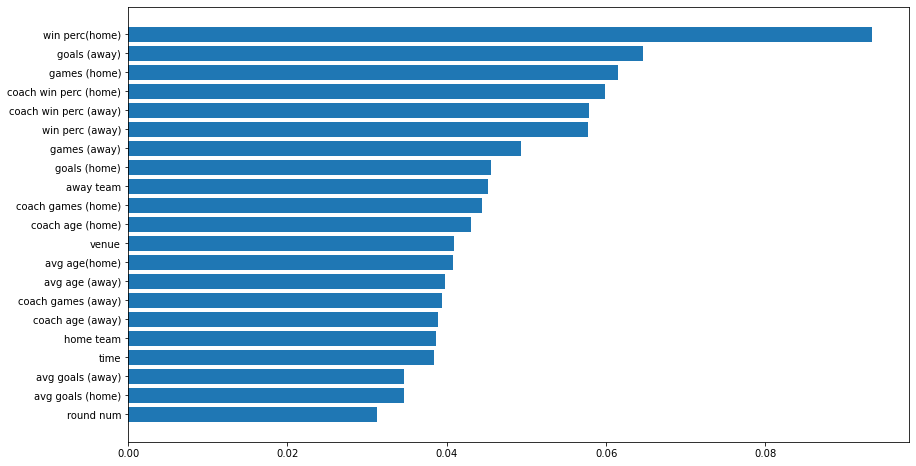

In [22]:
feature_labels = np.array(feature_labels)

importance = np.array(xgb_hyperopt.feature_importances_)
imp_sort = np.argsort(importance)
F = plt.figure(figsize=(14,8))
ax = F.add_subplot(111)
ax.barh(range(len(importance)),importance[imp_sort],tick_label=feature_labels[imp_sort])
plt.show()

So it seems that the best predictors of whether or not the home team wins are the win percentages of the coaches and teams, which is not particularly surprising. After that, we find features like total games and total goals, which likely are representative of the experience of each team. It seems as well that the actual teams, venue, and game time don't really matter too much.

The raw feature importance provided by XGBoost is fairly general, however and doesn't provide a deep insight into the decision making process. To get a deeper understanding, we can use SHapley Additive exPlanation (SHAP) values using the shap package:

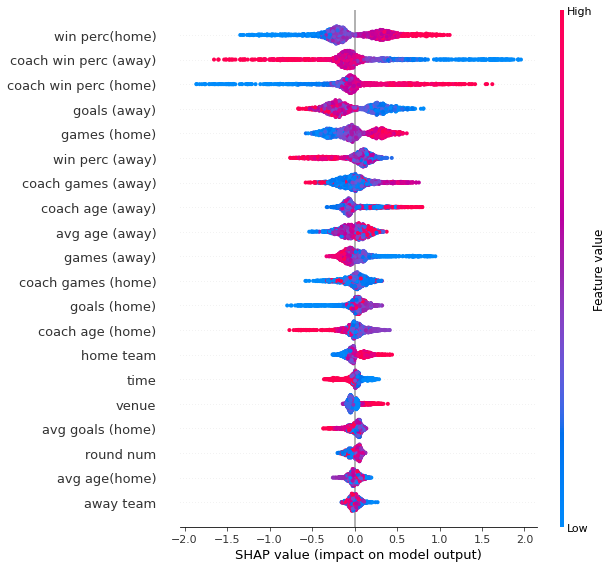

In [23]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb_hyperopt)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_labels)

AssertionError: 'shap_values' and 'features' values must have the same number of rows!

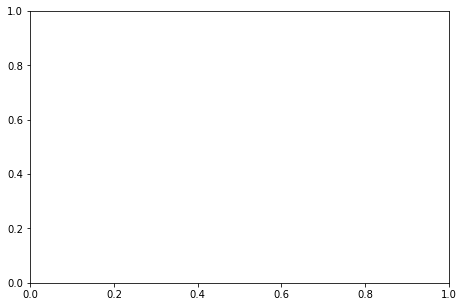

In [33]:
for i in range(len(feature_labels)):
    shap.dependence_plot(i, shap_values, X, feature_labels,interaction_index=1)#, display_features=feature_labels)

### Other ML Models

In many cases model training and selection really is as easy as this. Of course, there is a lot of stuff going on under the hood with these algorithms and certain algorithms may perform better from one case to another. A detailed discussion of the pros and cons of each model in the context of different types of problems is beyond the scope of this talk, so I leave it to you to explore further if inteterested. Regardless, there are a number of algorithms for classifying tabular data and they are remarkably easy to implement with sklearn.

To illustrate how easy it is to employ other types of models here are a few examples in sklearn:

In [29]:
# K-NEAREST NEIGHBORS (KNN)
from sklearn.neighbors import KNeighborsClassifier

KNNmod = KNeighborsClassifier().fit(X_train,y_train)




# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.preprocessing import StandardScaler

# Some models work best when training data is scaled to a similar order of magnitude*
scaler = StandardScaler()
scaler.fit(X_train)
Xtr = scaler.transform(X_train)
Xte = scaler.transform(X_test1)
Xt2 = scaler.transform(X_test2)

lrmod = LogReg(max_iter=10000).fit(Xtr,y_train)




# SUPPORT VECTOR MACHINE (SVM)
from sklearn.svm import SVC

svmod = SVC().fit(Xtr,y_train)




# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB

NBmod = GaussianNB().fit(Xtr,y_train)




# NEUARL NETWORK (slightly more complicated...)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

NNmod = Sequential()
NNmod.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
NNmod.add(Dropout(0.2))
NNmod.add(Dense(1, activation='sigmoid'))

NNmod.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
)

history = NNmod.fit(X_train,y_train,
                    batch_size=75,
                    epochs=50,
                    verbose=0,
                    validation_data=(X_test1,y_test1)
)




print(' Results for all our new models:')
print('---------------------------------------------------------------')
pred1  = xgb_hyperopt.predict(X_test1)
print(f'XGBoost 2018 accuracy = {acc(y_test1,pred1)}')
pred2  = xgb_hyperopt.predict(X_test2)
print(f'XGBoost 2019 accuracy = {acc(y_test2,pred2)}')
print('---------------------------------------------------------------')
print(f'KNN 2018 accuracy = {acc(y_test1,KNNmod.predict(X_test1))}')
print(f'KNN 2019 accuracy = {acc(y_test2,KNNmod.predict(X_test2))}')
print('---------------------------------------------------------------')
print(f'Logistic Regression 2018 accuracy = {acc(y_test1,lrmod.predict(Xte))}')
print(f'Logistic Regression 2019 accuracy = {acc(y_test2,lrmod.predict(Xt2))}')
print('---------------------------------------------------------------')
print(f'SVM 2018 accuracy = {acc(y_test1,svmod.predict(Xte))}')
print(f'SVM 2019 accuracy = {acc(y_test2,svmod.predict(Xt2))}')
print('---------------------------------------------------------------')
print(f'Naive Bayes 2018 accuracy = {acc(y_test1,NBmod.predict(Xte))}')
print(f'Naive Bayes 2019 accuracy = {acc(y_test2,NBmod.predict(Xt2))}')
print('---------------------------------------------------------------')
score = NNmod.evaluate(X_test1,y_test1,verbose=0)
print(f'Neural Net 2018 Accuracy = {score[1]}')
score = NNmod.evaluate(X_test2,y_test2,verbose=0)
print(f'Neural Net 2019 Accuracy = {score[1]}')

 Results for all our new models:
---------------------------------------------------------------
XGBoost 2018 accuracy = 0.7379156010230179
XGBoost 2019 accuracy = 0.5996078431372549
---------------------------------------------------------------
KNN 2018 accuracy = 0.6460358056265985
KNN 2019 accuracy = 0.6209803921568628
---------------------------------------------------------------
Logistic Regression 2018 accuracy = 0.7356777493606138
Logistic Regression 2019 accuracy = 0.6258823529411766
---------------------------------------------------------------
SVM 2018 accuracy = 0.7058184143222507
SVM 2019 accuracy = 0.5858823529411765
---------------------------------------------------------------
Naive Bayes 2018 accuracy = 0.7274936061381074
Naive Bayes 2019 accuracy = 0.6150980392156863
---------------------------------------------------------------
Neural Net 2018 Accuracy = 0.5762711763381958
Neural Net 2019 Accuracy = 0.6271186470985413


So it turns out that after all the trouble we went through to tune our XGBoost model to get the best hyperparameters, I simple, untuned logistic regression or naive bayes model does slightly better... go figure. It's possible that by identifying new features or by engineering new ones from those already available, we could improve the accuracy of our model and get better predictions. I spent a while trying to do this, but never got any significant improvement. 

### How'd we do?

So in the end we were able to predict AFL matches in 2018 and 2019 with ~73% and ~63% accuracy. There is actually a fair bit of literature in the field of AI sports outcome prediction, and it turns out that these accuracies are in the ballpark for the best performing models across a range of sports. It's likely that no matter what we do, we simply won't do much better than this. This likely just reflects the fact that there is a fair bit of chance when it comes to sport... which is a good thing as it would be pretty boring if we always knew who was going to win from the start!